# Trending words

Let's analyze which words appear most often on a given day relative to a baseline. We can also do an n-grams-style line chart of which words tend to appear over time the most.

In [2]:
from jupyter_cms.loader import load_notebook

eda = load_notebook('./data_exploration.ipynb')

df, newspapers = eda.load_data()

In [6]:
import pandas as pd

pd.set_option('display.max_columns', 100)

In [7]:
df.head(3)

,text,fontface,fontsize,bbox_left,bbox_bottom,bbox_right,bbox_top,bbox_area,avg_character_area,percent_of_page,page,page_width,page_height,page_area,date,day_of_week,weekend,slug,id,page_height_round,page_width_round,page_width_round_10,page_height_round_10,aspect_ratio
9,A blast on a subway killed 11 \npeople Monday....,FrugalSans-Light-DTC,12.177,55.062,230.002,166.022,268.579,4280.50392,50.108339,0.003269,1,801.0,1634.976,1309615.776,2017-04-04,1,False,VA_DNR,40876,1634,801,800,1630,0.5
11,"Donna R. Adkins, 68, \nBridgewater \nCalvin E....",CKLDCP+FranklinGothic-Demi,12.570,368.620,249.330,489.200,322.180,8784.25300,56.935536,0.006708,1,801.0,1634.976,1309615.776,2017-04-04,1,False,VA_DNR,40878,1634,801,800,1630,0.5
12,"Nancy M. Lawrence, 86, Elkton \nOlive V. Roop,...",CKLIDL+FranklinGothic-Book,12.850,509.320,249.330,639.739,322.180,9501.02415,56.830592,0.007255,1,801.0,1634.976,1309615.776,2017-04-04,1,False,VA_DNR,40879,1634,801,800,1630,0.5


In [10]:
print('''Rows: {}
Dates: {} ({} - {})
'''.format(
    df.shape[0],
    df.date.nunique(),
    df.date.min(),
    df.date.max()
))

Rows: 796938
Dates: 105 (2017-04-01 00:00:00 - 2017-07-23 00:00:00)


In [14]:
import spacy

nlp = spacy.load('en')

In [41]:
docs = []
for i, doc in enumerate(nlp.pipe(df.text, batch_size=10000, n_threads=7)):
    if i % 5000 == 0:
        print('.', end='')
    docs.append(doc)

................................................................................................................................................................

In [268]:
def remove_token(t):
    return not t.is_alpha or t.is_stop

In [270]:
lemmas = []

for d in docs:
    d_lemmas = []
    for t in d:
        if not remove_token(t):
            d_lemmas.append(t.lemma_)
    
    lemmas.append(d_lemmas)

In [271]:
import itertools
df['lemmas'] = lemmas

In [346]:
newspaper_text = df.groupby(['date']).lemmas.apply(lambda x: list(itertools.chain(*x)))
newspapers_per_day = df.groupby(['date']).slug.nunique()

In [357]:
import sys
from collections import Counter

newspaper_tfs = []

# tf - number of times word shows up in current document
# doc_freqs - number of documents that has a given word

for i, d in enumerate(newspaper_text):
    if i % 10000 == 0:
        print('.', end='')
        sys.stdout.flush()
    tf = Counter(d)
    newspaper_tfs.append(tf)

.

To detect anomolously high usage of a word on a day, we want several things:

* High usage of the word relative to a baseline (every other day)
* High usage of the word in general. For example, it isn't as meaningful to have a single word used once, and to say that it is infinitely more common in that one particular document.
* To avoid the situation where a document itself will overwhelm the entire corpus through frequent usage of a term.

We also want a multi-level model that will estimate two things in tandem: the presence of clusters of topics, as well as anomolous vocabulary usage _within_ each topic.

Already we can compare two numbers: how frequently a word appears in the text vs. how frequently it appears in other documents that mention that word.

In [398]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

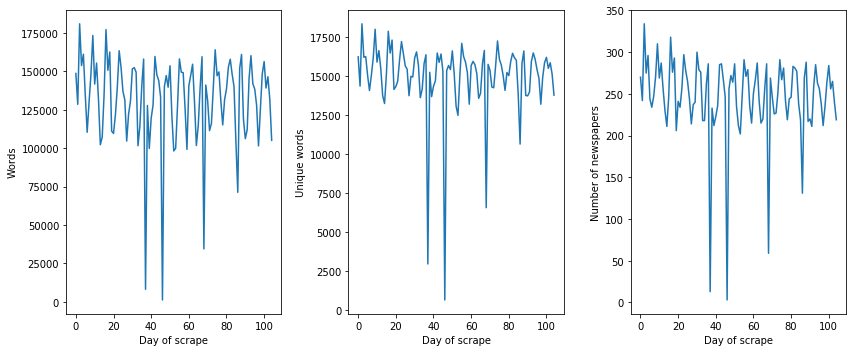

In [423]:
fig = plt.figure(figsize=(12, 5))
plot1 = fig.add_subplot(131)
plot2 = fig.add_subplot(132)
plot3 = fig.add_subplot(133)

plot1.plot(range(len(newspaper_text)), [len(text) for text in newspaper_text])
plot1.set_xlabel("Day of scrape")
plot1.set_ylabel("Words")

plot2.plot(range(len(day_vocab_props)), [len(x) for x in day_vocab_props])
plot2.set_xlabel("Day of scrape")
plot2.set_ylabel("Unique words")

plot3.plot(range(len(newspapers_per_day)), newspapers_per_day.values)
plot3.set_xlabel("Day of scrape")
plot3.set_ylabel("Number of newspapers")
plt.tight_layout()

In [438]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer()
X = dv.fit_transform(newspaper_tfs)

In [468]:
from sklearn.feature_selection import chi2

def get_labels_for_day(day, N):
    arr = np.zeros(N)
    arr[day] = 1
    
    return arr

get_labels_for_day(2, 5)

array([ 0.,  0.,  1.,  0.,  0.])

In [ ]:
N = len(newspaper_tfs)
words = np.array(dv.get_feature_names())

In [502]:
top_words_by_day = []

for i in range(N):
    print('.', end = '')
    sys.stdout.flush()
    
    keyness, _ = chi2(X, get_labels_for_day(i, N))
    ranking = np.argsort(keyness)[::-1]
    top_words = words[ranking]
    top_words_by_day.append(list(zip(top_words, keyness[ranking])))

.........................................................................................................

In [506]:
sum([sys.getsizeof(x) for x in top_words_by_day])

148002120

In [536]:
for date, top_words in zip(newspaper_meta, top_words_by_day):
    print('.', end='')
    sys.stdout.flush()
    
    date_str = pd.to_datetime(str(date)).strftime('%Y-%m-%d')
    
    with open('results/top-words/{}.csv'.format(date_str), 'w') as out:
        out.write('\n'.join([','.join([line[0], str(np.round(line[1], 2))]) for line in top_words]))

.........................................................................................................

In [539]:
newspaper_day_text = df.groupby(['date', 'slug']).lemmas.apply(lambda x: list(itertools.chain(*x)))

In [549]:
newspaper_day_meta = df.groupby(['date', 'slug']).first().reset_index()[['date', 'slug']]

In [654]:
newspaper_day_tf = []

for lemmas in newspaper_day_text:
    newspaper_day_tf.append(Counter([lemma for lemma in lemmas if len(lemma) > 2]))

In [655]:
dv = DictVectorizer()
X = dv.fit_transform(newspaper_day_tf)

In [656]:
newspaper_day_tf = np.array(newspaper_day_tf)

In [620]:
def get_day(day):
    date = newspaper_day_meta.date.unique()[day]
    return newspaper_day_meta[newspaper_day_meta.date == date].index

In [608]:
def get_slug_in_day(slug, day):
    date = newspaper_day_meta.date.unique()[day]
    ndf = newspaper_day_meta[newspaper_day_meta.date == date].reset_index()
    return ndf[ndf.slug == slug].index[0]

In [615]:
def get_day_slugs(day):
    date = newspaper_day_meta.date.unique()[day]
    return newspaper_day_meta[newspaper_day_meta.date == date].slug.values

In [ ]:
top_words_by_slug_day = []
words = np.array(dv.get_feature_names())

for i in range(N):
    print('.', end = '')
    sys.stdout.flush()
    
    day_ix = get_day(i)
    X_universe = X[day_ix, ]
    
    day_slugs = get_day_slugs(i)
    M = len(day_slugs)
    for slug in day_slugs:
        j = get_slug_in_day(slug, i)
        
        keyness, _ = chi2(X_universe, get_labels_for_day(j, M))
        ranking = np.argsort(np.nan_to_num(keyness))[::-1]
        top_words = words[ranking[:100]]
        top_words_by_slug_day.append(top_words)

...

KeyboardInterrupt: 

In [ ]:
len(top_words_by_slug_day)

In [ ]:
1

In [ ]:
1